# Planning search heuristic analysis

Prepared by nate@respawn.io for AIND Planning assignment.


### Utils

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

## Optimal plans for airport cargo problems 1-3

#### Problem 1: 2 cargos, 2 planes, 2 airports

6 actions total, obviously we need at least 3 actions per cargo item (load, fly, unload), so any optimal plan would have 6 actions. 

```
Load(C1, P1, SFO)
Fly(P1, SFO, JFK)
Load(C2, P2, JFK)
Fly(P2, JFK, SFO)
Unload(C1, P1, JFK)
Unload(C2, P2, SFO)
```

#### Problem 2: 3 cargos, 3 planes, 3 airports

9 actions, 3 per cargo, ok.

```
Load(C3, P3, ATL)
Fly(P3, ATL, SFO)
Unload(C3, P3, SFO)
Load(C1, P1, SFO)
Fly(P1, SFO, JFK)
Unload(C1, P1, JFK)
Load(C2, P2, JFK)
Fly(P2, JFK, SFO)
Unload(C2, P2, SFO)
```


#### Problem 3: 4 cargos, 2 planes, 4 airports

Assumint one plane can hold more than one cargo — that's an optimal plan with 12 actions.

```
Load(C2, P2, JFK)
Fly(P2, JFK, ORD)
Load(C4, P2, ORD)
Fly(P2, ORD, SFO)
Unload(C4, P2, SFO)
Load(C1, P1, SFO)
Fly(P1, SFO, ATL)
Load(C3, P1, ATL)
Fly(P1, ATL, JFK)
Unload(C3, P1, JFK)
Unload(C2, P2, SFO)
Unload(C1, P1, JFK)
```


In [26]:
results = pd.read_csv('searches_data.csv')

In [27]:
results

,problem,alg,expansions,goal tests,new nodes,time,optimal
0,Problem 1,bfs,43.0,56.0,180.0,0.034162,True
1,Problem 1,dfs,21.0,22.0,84.0,0.020853,False
2,Problem 1,ucs,55.0,57.0,224.0,0.040000,True
3,Problem 2,bfs,3343.0,4609.0,30509.0,14.984030,Tree
4,Problem 2,dfs,624.0,625.0,5602.0,4.050000,False
5,Problem 2,ucs,4852.0,4854.0,44030.0,12.930000,True
6,Problem 3,bfs,14663.0,18098.0,129631.0,114.600000,True
7,Problem 3,dfs,408.0,409.0,3364.0,2.060000,False
8,Problem 3,ucs,18235.0,18237.0,159716.0,61.966000,True
9,Problem 1,ignore_preconditions,41.0,43.0,170.0,0.054000,True


### Notes on uninformed search algorithms 

- I've tried to compare to tree-search algs (bfs & dfs over a tree without expanded set), which just take too long to finish for p2 and p3. 
- BFS tends to be the slowest algorithm on larger problems. 
- DFS is fast and cheap memory-wise, but doesn't guarantee an optimal plan.
- UCS tends to be 2 times cheaper than BFS on execution time, but a bit more expensive on memory. That is if the cost is a known constant and is not calculated on the fly. 

Overall, these algorithms won't really work for a big enough problem in a reasonable time with a reasonable hardware.

### Notes on heuristic algorighms


#### `ignore_preconditions` 

`ignore_preconditions` works vert fast, and it's heuristic is admisable, however it feels like cheat given that the heuristic, in our case, is a stupid one, just the amount of unmet goals. 

#### Inadmisable `ignore_preconditions_alternative`

I've tried to come up with an alternative heuristic for ignoring some preconditions: number of unmet goals plus number of unique unmet preconditions for those goals. This won't be admisable because it can overestimate the total cost, but it converges VERY fast. I've included it into this comparison, just for fun.

In a way, it tries to estimate what planning graph would do, without mutexes and just for 2 levels (goal, goal-1). Solves Problem 3 with an optimal plan in 1.13 seconds versus 300+ seconds for `pg_levelsum`.

#### Planing Graph Levelsum

`pg_levelsum` is slow, because calculating the whole planning graph with all the mutex conditions is slow. It should also be pretty expensive on memory. But when it's done, the resulting heuristic performs the best out of all the other heuristics we've researched. The plan search is very memory and time effecient with it. 

### Execution time

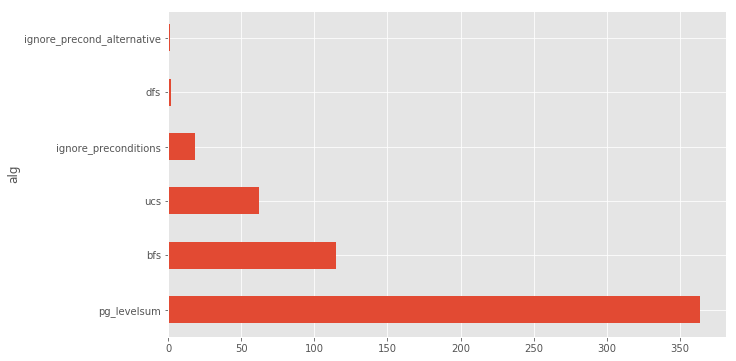

In [41]:
results[ results.problem == 'Problem 3' ].set_index('alg').sort_values('time', ascending=False).time.plot(kind='barh', figsize=(10,6))

Given that `ignore_precond_alternative` is inadmisable and `dfs` renders suboptimal plan, the fastest heuristic is `ignore_preconditions`. 

### Expanded nodes

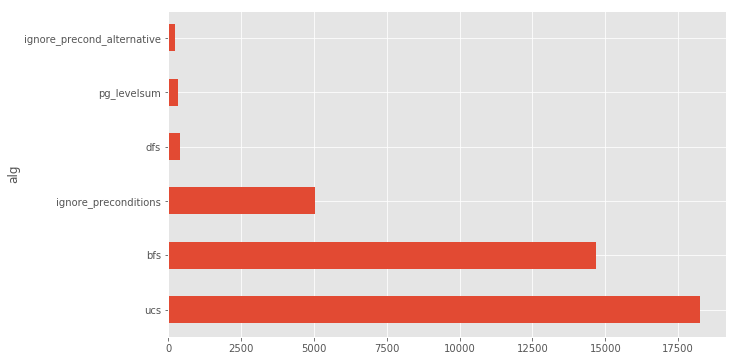

In [44]:
results[ results.problem == 'Problem 3' ].set_index('alg').sort_values('expansions', ascending=False).expansions.plot(kind='barh', figsize=(10,6))

If we're to ignore the time and memory `pg_levelsum` uses to initially build the Planning Graph, than it's by far the best alg out there.

Alternatively, `ignore_preconditions` performs reasonably well if well implemented (cheap to calculate, admisable). That way we can save on calculating the planning graph.